In [1]:
import os, sys

In [2]:
# Check if extracted data folder exists
usingColab = 0
if usingColab:
  if(not os.path.exists('SYSC4415W23_A3_dataset')):

    # Download and extract the dataset if the zip file does not exist
    if (not os.path.isfile('SYSC4415W23_A3_dataset.zip')):
      !wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment3/SYSC4415W23_A3_dataset.zip
      !unzip SYSC4415W23_A3_dataset.zip

  datasetPath = r"SYSC4415W23_A3_dataset"

else:
  datasetPath = r"C:/Users/googl/Documents/ML/A3_Dataset/SYSC4415W23_A3_dataset"

In [3]:
import pandas as pd

train_labels = pd.read_csv(f'{datasetPath}/train/labels.csv')
train_features = pd.read_csv(f'{datasetPath}/train/extracted_features.csv')

train_features.set_index(keys='sample_id', inplace=True)
train_features.sort_values(by=['sample_id'], inplace=True)
train_labels.set_index(keys='sample_id', inplace=True)
train_labels.sort_values(by=['sample_id'], inplace=True)

print(f'Shape of original features: {train_features.shape}')

Shape of original features: (1621, 7047)


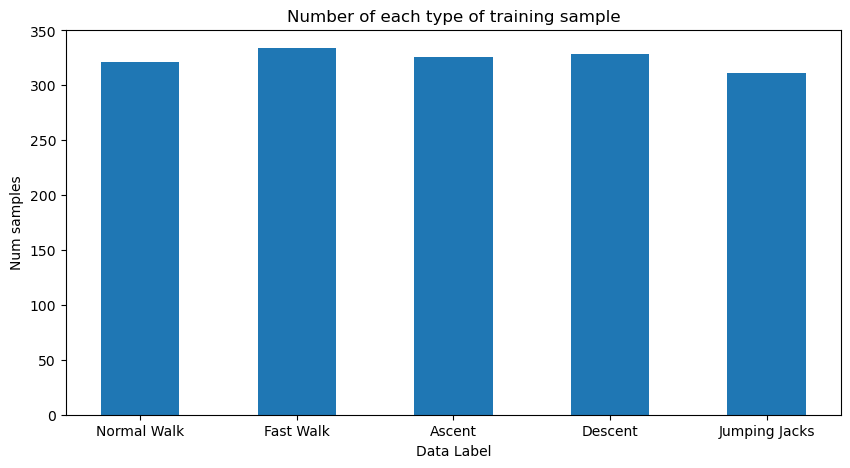

In [4]:
# Data visualization
import matplotlib.pyplot as plt
counts = train_labels.value_counts(subset=['label'])
keys = ['Normal Walk', 'Fast Walk', 'Ascent', 'Descent', 'Jumping Jacks']
vals = [counts[0],counts[1], counts[2], counts[3], counts[4]]

fig = plt.figure(figsize=(10,5))
plt.bar(x=keys, height=vals, width=0.5)
plt.xlabel("Data Label")
plt.ylabel("Num samples")
plt.title("Number of each type of training sample")
plt.show()

# No class imbalance

### Feature Selection 
Using variance thresholding, dropping any features with NaN values and using univariate stats to determince the top 50% of features for classification to determine which features are useful.

In [5]:
# Remove features that have very low variance
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

sel = VarianceThreshold(threshold=(0.95 * (1 - 0.95)))
sel.fit_transform(train_features)
cols = [column for column in train_features.columns 
          if column not in train_features.columns[sel.get_support()]]
trimTrainFeat = train_features.drop(columns=cols)
print(f'Shape after variance threshold of .9525: {trimTrainFeat.shape}')

toDrop_o = trimTrainFeat.isnull().sum().to_numpy()
toDrop = [True]*len(toDrop_o)
for val in range(len(toDrop)):
    if toDrop_o[val] > 0:
        toDrop[val] = False
    else:
        toDrop[val] = True

dropped = [column for column in trimTrainFeat.columns 
          if column not in trimTrainFeat.columns[toDrop]]
dataset = trimTrainFeat.drop(columns=dropped)

print(f'Number of reduced features from removing NaN values: {dataset.shape}')

# Using top 50% of features
nextSel = SelectKBest(score_func=f_classif, k=1500)
nextSel.fit_transform(dataset, train_labels['label'])
cols = [column for column in dataset.columns 
          if column not in dataset.columns[nextSel.get_support()]]
dataset = dataset.drop(columns=cols)
print(f'Feature data shape after SelectKBest using f-value stats: {dataset.shape}')

# Free up memory for next tasks
del trimTrainFeat, toDrop, dropped, cols, sel, nextSel, toDrop_o


c:\Users\googl\microconda\envs\ML\lib\site-packages\sklearn\feature_selection\_variance_threshold.py:111: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


Shape after variance threshold of .9525: (1621, 5423)
Number of reduced features from removing NaN values: (1621, 5402)
Feature data shape after SelectKBest using f-value stats: (1621, 1500)


#### Data Loading and organization

In [6]:
# from torch.utils.data import DataLoader
batchSize = 32
tr_split = 1300 # ~80% of labelled data
te_split = 321  # ~10% of labelled data

dataset['label'] = train_labels['label']
dataset = dataset.sample(frac=1) # Shuffle rows before breaking into sets

trainSet = dataset.iloc[:tr_split] # Shape: 1300, 2701
testSet = dataset.iloc[tr_split:]  # Shape: 321, 2701

### Building model
**Hyperparameters**: 
- Learning rate: Using effective LR calculated from base LR using:
$$\eta_{eff} = \frac{B\eta_{base}}{256}$$
- Input size: 2700
- Output size: 5 (1 per class label)
- Hiddel layers: 1
- Nodes/hidden layer: 1800 (2/3 of input size, since input size > num samples)

In [7]:
from sklearn.neural_network import MLPClassifier
import time
lr_base = 0.0001

lr = (batchSize*lr_base)/256
MLP = MLPClassifier((1000,), 'relu', solver='adam', learning_rate_init=lr, max_iter=1500, batch_size=batchSize)
trainData = trainSet.iloc[:, :-1] # 1300, 1500
trainLabels = trainSet.iloc[1:,-1] # 1300, 1

start = time.time()
MLP.fit(trainData, trainLabels)
print(time.time() - start)

302.7653820514679


In [10]:
from sklearn.metrics import accuracy_score

testCols = testSet.columns
for col in trainSet.columns:
  if col not in testCols:
    testSet.drop(columns=col)

testData = testSet.iloc[:, :-1] # 321, 1500
testLabels = testSet.iloc[:,-1] # 321, 1

trainLabelsEx = MLP.predict(X=trainData) # output 1300, 1
testLabelsEx = MLP.predict(X=testData) # output 321, 1


tr_score = accuracy_score(trainLabels, trainLabelsEx)
te_score = accuracy_score(testLabels, testLabelsEx)



# for te_lbl, tr_lbl in 
print(f"Train accuracy: {tr_score}")
print(f"Test accuracy: {te_score}")


(321, 1500)
Train accuracy: 0.9315384615384615
Test accuracy: 0.7133956386292835
